In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# # [전제] 필요한 패키지 import 및 device 설정
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # 1. 모델 정의 (커널 재시작 후 다시 실행 필요)
# class DummyAnyNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(6, 64, 3, 1, 1),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, 3, 1, 1),
#             nn.ReLU(),
#             nn.Conv2d(64, 1, 3, 1, 1)
#         )

#     def forward(self, left, right):
#         x = torch.cat([left, right], dim=1)
#         return self.encoder(x)

# # 2. 모델 불러오기
# model = DummyAnyNet().to(device)
# model.load_state_dict(torch.load('checkpoints/dummyanynet_epoch10.pth'))
# model.eval()
# print("✅ 모델 로드 완료 및 추론 모드 설정됨")

✅ 모델 로드 완료 및 추론 모드 설정됨


C:\Users\espin\AppData\Local\Temp\ipykernel_132680\2093780566.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/dummyanynet_

In [2]:
# ✅ 1. Dataset
class MyStereoDataset(Dataset):
    def __init__(self, left_dir, right_dir):
        self.left_images = sorted([os.path.join(left_dir, f) for f in os.listdir(left_dir) if f.endswith('.png')])
        self.right_images = sorted([os.path.join(right_dir, f) for f in os.listdir(right_dir) if f.endswith('.png')])
        self.transform = T.Compose([
            T.Resize((256, 512)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.left_images)

    def __getitem__(self, idx):
        left = Image.open(self.left_images[idx]).convert('RGB')
        right = Image.open(self.right_images[idx]).convert('RGB')
        return self.transform(left), self.transform(right)

In [3]:
# ✅ 2. Dummy AnyNet 구조 (간단화된 버전)
class DummyAnyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, 1, 1)
        )

    def forward(self, left, right):
        x = torch.cat([left, right], dim=1)
        disp = self.encoder(x)
        return disp * 64  # 시차 스케일 조정 👉 **필수**


In [4]:
def photometric_loss(left, right, disp):
    B, C, H, W = left.shape

    # base grid 생성
    y, x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    x = x.to(disp.device).float()
    y = y.to(disp.device).float()

    # disparity 적용
    x = x.unsqueeze(0).expand(B, -1, -1)  # [B, H, W]
    y = y.unsqueeze(0).expand(B, -1, -1)

    x_warp = x - disp.squeeze(1)  # disparity만큼 좌측 이동

    # 정규화 (-1 ~ 1)
    x_warp_norm = 2.0 * x_warp / (W - 1) - 1.0
    y_norm = 2.0 * y / (H - 1) - 1.0

    # [B, H, W, 2] → grid_sample에 넣기 위한 형태
    grid = torch.stack((x_warp_norm, y_norm), dim=3)

    # 좌 → 우 이미지 warp해서 비교
    right_warped = nn.functional.grid_sample(right, grid, align_corners=True)
    loss = nn.functional.l1_loss(left, right_warped)

    return loss

✅ 학습 데이터셋 이미지 수: 7481쌍
[Epoch 1 - Batch 0] Loss: 0.1264
[Epoch 1 - Batch 100] Loss: 0.0823
[Epoch 1 - Batch 200] Loss: 0.0679
[Epoch 1 - Batch 300] Loss: 0.0715
[Epoch 1 - Batch 400] Loss: 0.0634
[Epoch 1 - Batch 500] Loss: 0.0749
[Epoch 1 - Batch 600] Loss: 0.0583
[Epoch 1 - Batch 700] Loss: 0.0778
[Epoch 1 - Batch 800] Loss: 0.0564
[Epoch 1 - Batch 900] Loss: 0.0474
[Epoch 1 - Batch 1000] Loss: 0.0681
[Epoch 1 - Batch 1100] Loss: 0.0750
[Epoch 1 - Batch 1200] Loss: 0.0566
[Epoch 1 - Batch 1300] Loss: 0.0662
[Epoch 1 - Batch 1400] Loss: 0.0484
[Epoch 1 - Batch 1500] Loss: 0.0450
[Epoch 1 - Batch 1600] Loss: 0.0525
[Epoch 1 - Batch 1700] Loss: 0.0532
[Epoch 1 - Batch 1800] Loss: 0.0554
Epoch 1, Average Loss: 0.0606
[Epoch 2 - Batch 0] Loss: 0.0574
[Epoch 2 - Batch 100] Loss: 0.0594
[Epoch 2 - Batch 200] Loss: 0.0476
[Epoch 2 - Batch 300] Loss: 0.0597
[Epoch 2 - Batch 400] Loss: 0.0514
[Epoch 2 - Batch 500] Loss: 0.0599
[Epoch 2 - Batch 600] Loss: 0.0474
[Epoch 2 - Batch 700] Loss: 0.04

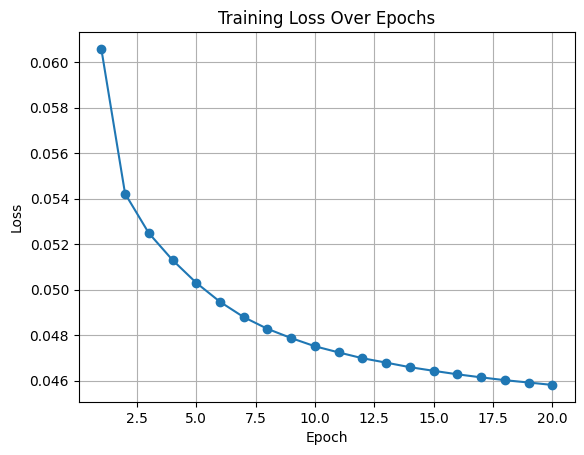

In [5]:
# ✅ 4. 학습 루프 + Loss 그래프 + 데이터셋 확인 출력
left_dir = 'data_object_image/training/left'
right_dir = 'data_object_image/training/right'
dataset = MyStereoDataset(left_dir, right_dir)
print(f"✅ 학습 데이터셋 이미지 수: {len(dataset)}쌍")
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DummyAnyNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_history = []  # 📊 Loss 시각화용 리스트

for epoch in range(20):
    total_loss = 0
    for batch_idx, (left, right) in enumerate(dataloader):
        left, right = left.to(device), right.to(device)
        disp = model(left, right)
        loss = photometric_loss(left, right, disp)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f"[Epoch {epoch+1} - Batch {batch_idx}] Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

# ✅ 학습 종료 후 loss 그래프 출력
import matplotlib.pyplot as plt
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

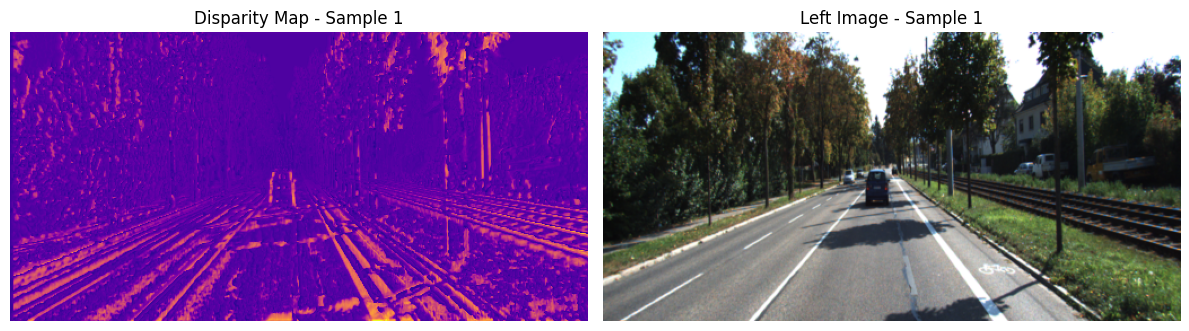

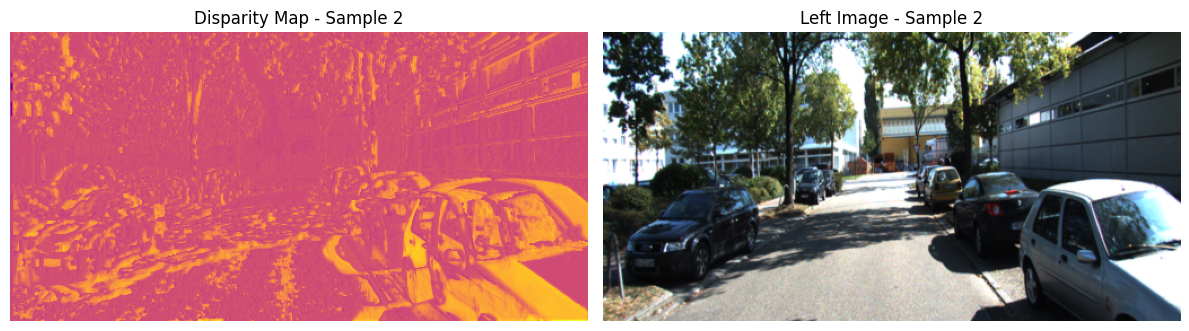

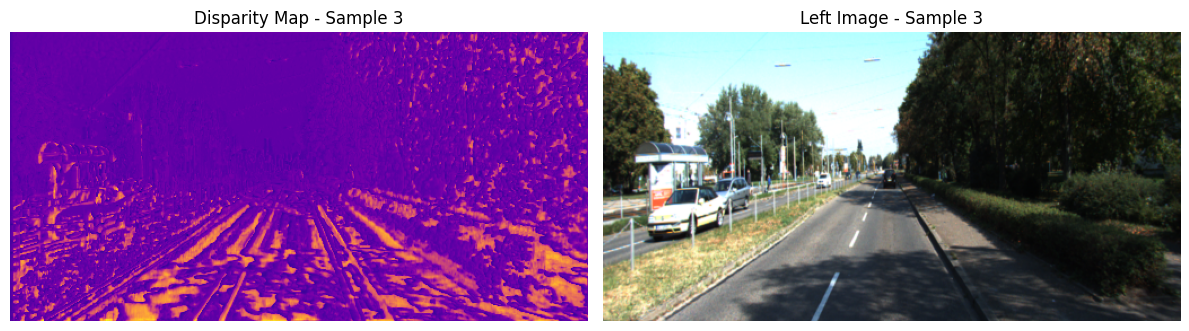

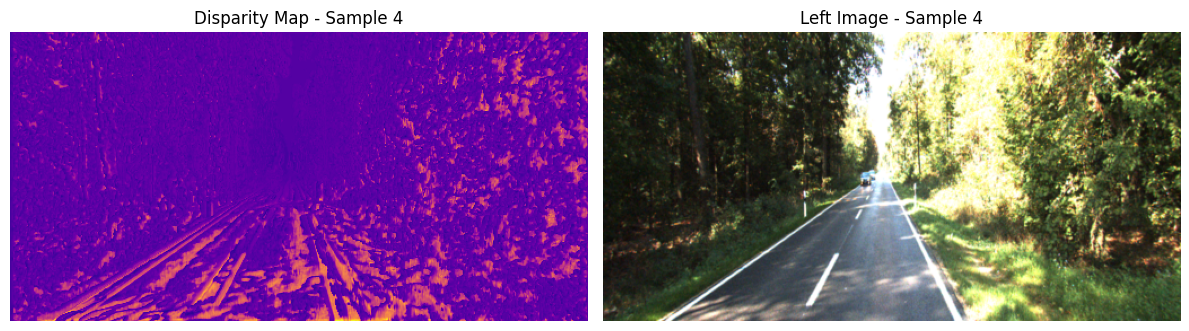

In [7]:
# 배치 하나 가져와 추론
left, right = next(iter(dataloader))
with torch.no_grad():
    disp_batch = model(left.to(device), right.to(device)).cpu().squeeze(1)

# 배치 내 모든 시차맵 + 좌측 원본 이미지 시각화
for i in range(disp_batch.shape[0]):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # 좌: 시차맵
    axs[0].imshow(disp_batch[i].numpy(), cmap='plasma')
    axs[0].set_title(f'Disparity Map - Sample {i+1}')
    axs[0].axis('off')
    
    # 우: 좌측 원본 이미지
    axs[1].imshow(left[i].permute(1, 2, 0).numpy())  # [C, H, W] → [H, W, C]
    axs[1].set_title(f'Left Image - Sample {i+1}')
    axs[1].axis('off')
    
    plt.tight_layout()
    plt.show()


In [8]:
# 모델 저장 (epoch 기준 이름 부여)
save_path = 'checkpoints/dummyanynet_epoch20.pth'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"✅ 모델 저장 완료: {save_path}")


✅ 모델 저장 완료: checkpoints/dummyanynet_epoch20.pth


In [9]:
# %% ✅ 시차 → 깊이 변환 함수 정의
def disparity_to_depth(disparity_map, focal_length=721.0, baseline=0.54, eps=1e-6):
    """
    시차맵을 깊이맵으로 변환
    - disparity_map: numpy or tensor [H, W]
    - focal_length: KITTI 기준 기본값
    - baseline: 카메라 거리 (단위: meter)
    """
    return (focal_length * baseline) / (disparity_map + eps)

Sample 1 depth min: -12181581.00, max: 2196916.50


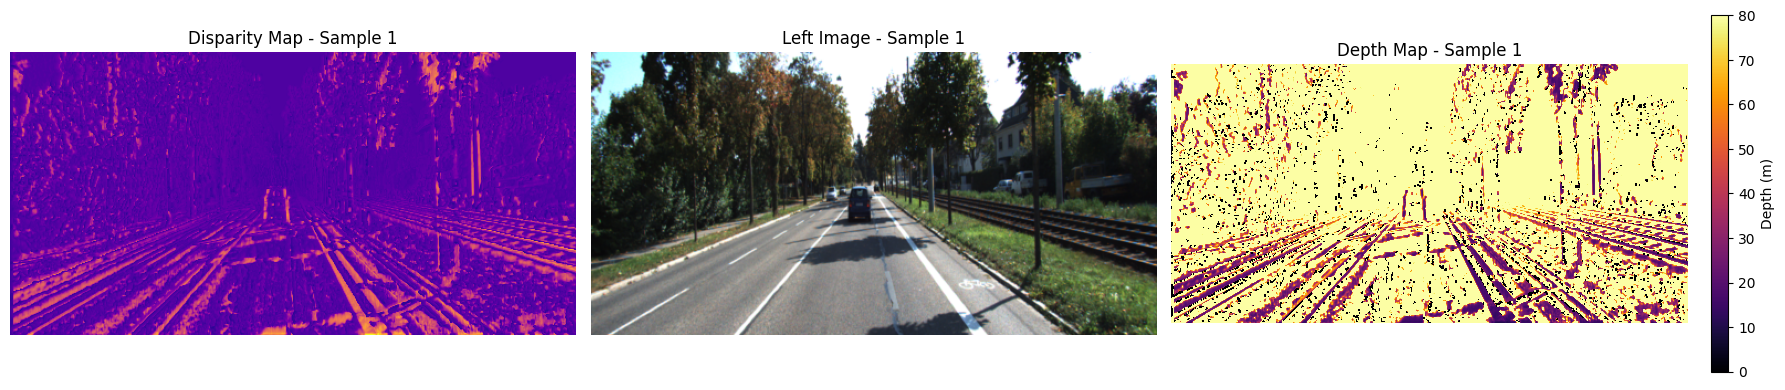

Sample 2 depth min: -9378746.00, max: 17993254.00


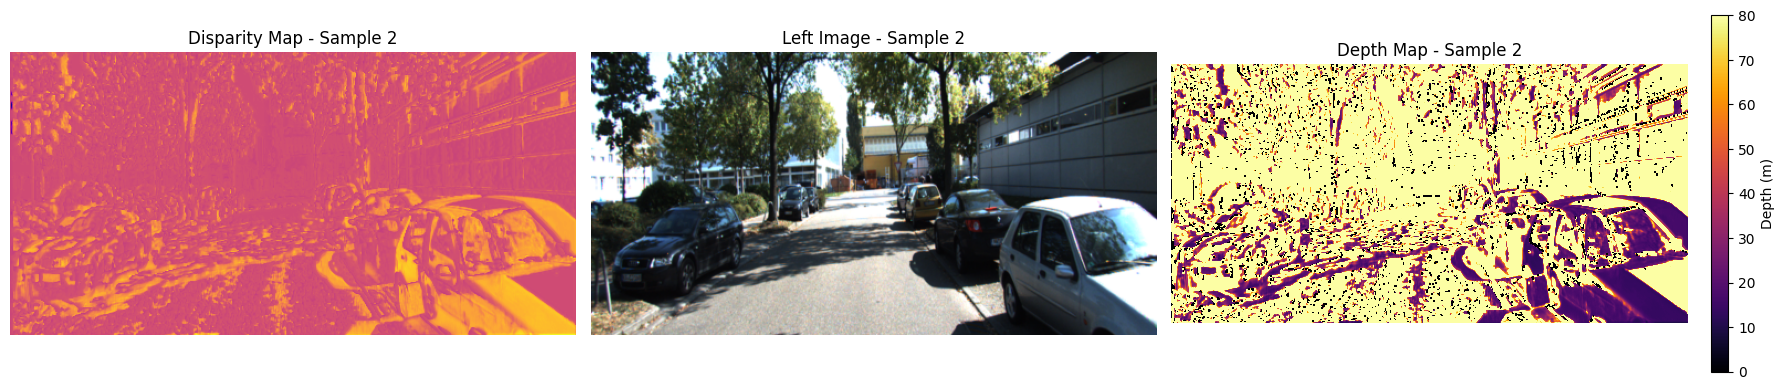

Sample 3 depth min: -6588220.50, max: 2072988.00


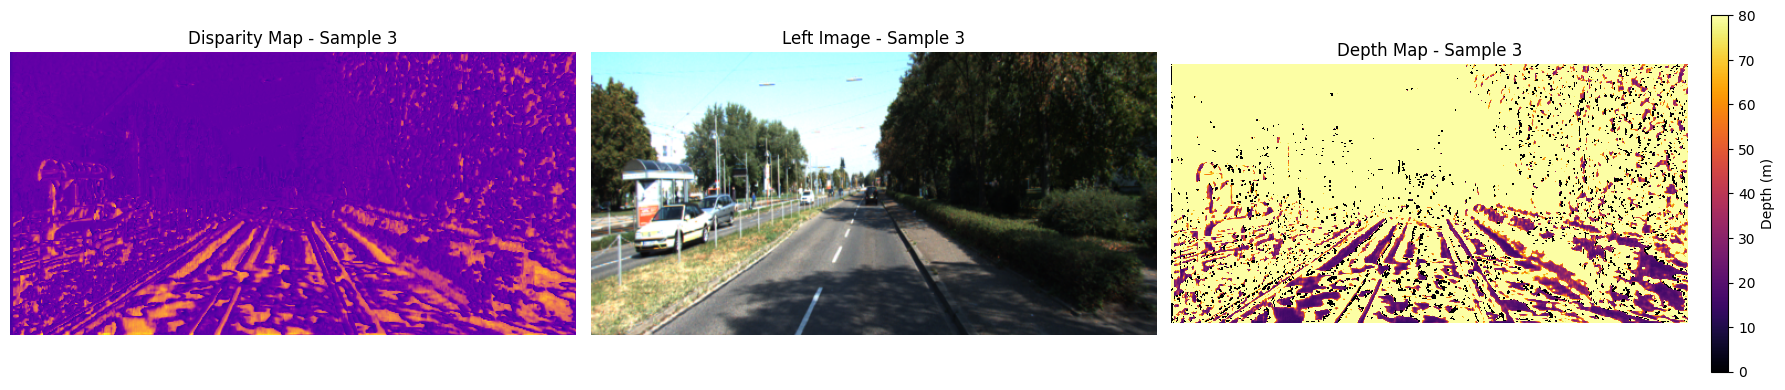

Sample 4 depth min: -8712609.00, max: 1820510.50


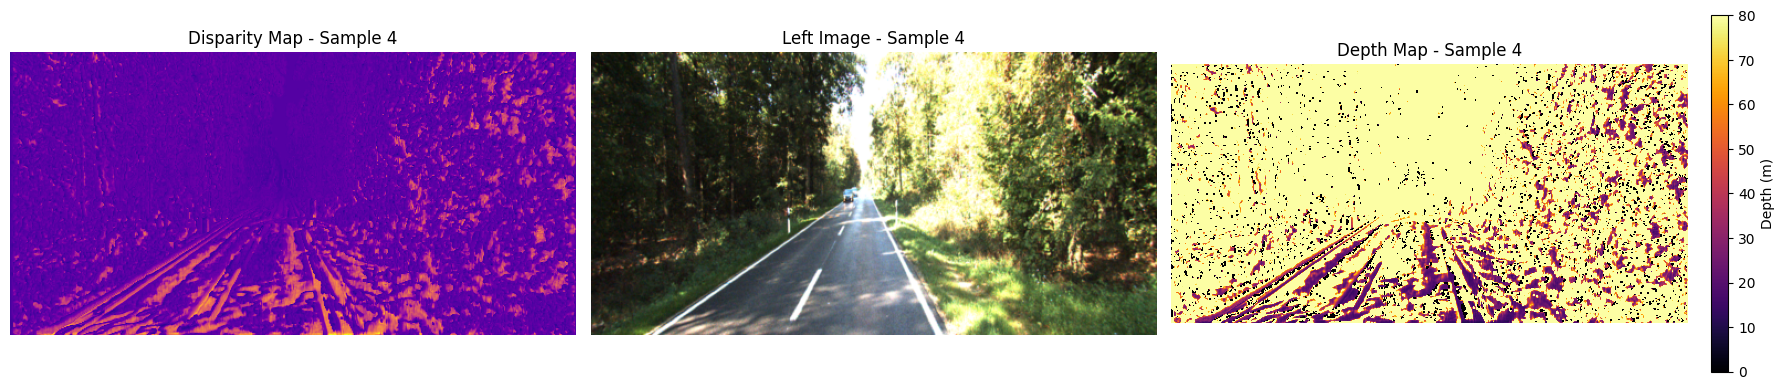

In [10]:
# %% ✅ 배치 내 샘플별 깊이맵 계산 및 시각화
for i in range(disp_batch.shape[0]):
    disp_np = disp_batch[i].numpy()
    depth_map = disparity_to_depth(disp_np)

    # 깊이값 확인
    print(f"Sample {i+1} depth min: {depth_map.min():.2f}, max: {depth_map.max():.2f}")

    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # 시차맵
    axs[0].imshow(disp_np, cmap='plasma')
    axs[0].set_title(f'Disparity Map - Sample {i+1}')
    axs[0].axis('off')

    # 좌측 원본
    axs[1].imshow(left[i].permute(1, 2, 0).numpy())
    axs[1].set_title(f'Left Image - Sample {i+1}')
    axs[1].axis('off')

    # 깊이맵 (범위 고정)
    depth_vis = axs[2].imshow(depth_map, cmap='inferno', vmin=0, vmax=80)
    axs[2].set_title(f'Depth Map - Sample {i+1}')
    axs[2].axis('off')

    fig.colorbar(depth_vis, ax=axs[2], fraction=0.046, pad=0.04, label='Depth (m)')
    plt.tight_layout()
    plt.show()

In [11]:
# %% ✅ 포인트 클라우드 생성 및 시각화 (개선 버전)
import open3d as o3d
import cv2
import numpy as np

def create_point_cloud_open3d(disparity_map, left_img, focal_length=721.0, baseline=0.54):
    h, w = disparity_map.shape

    Q = np.float32([
        [1, 0, 0, -w / 2],
        [0, -1, 0, h / 2],
        [0, 0, 0, -focal_length],
        [0, 0, 1 / baseline, 0]
    ])

    # 3D 포인트 재투영
    points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
    colors = (left_img * 255).astype(np.uint8)

    # 유효한 시차 조건 (disparity > 작은 값, NaN 방지)
    mask = disparity_map > 1.0
    output_points = points_3D[mask]
    output_colors = colors[mask]

    return output_points, output_colors

# Sample 기준
disp_np = disp_batch[0].numpy()
left_np = left[0].permute(1, 2, 0).numpy()

points, colors = create_point_cloud_open3d(disp_np, left_np)

# ✅ 포인트 스케일 다운 (Open3D는 단위 m 정도가 적절)
points_scaled = points / 100.0  # 스케일 조정 (너무 크면 축소)

# Open3D 객체 생성 및 중심 정렬
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_scaled)
pcd.colors = o3d.utility.Vector3dVector(colors / 255.0)
pcd.translate(-pcd.get_center())

# 출력 확인
print(f"✅ 유효 포인트 수: {len(points_scaled)}")
print(f"예시 포인트 좌표: {points_scaled[0]}")
print(f"예시 색상: {colors[0]}")

# Open3D 시각화
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="3D Point Cloud Viewer")
vis.add_geometry(pcd)
vis.get_view_control().set_zoom(0.5)  # 적당한 줌 설정
vis.run()
vis.destroy_window()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
✅ 유효 포인트 수: 116122
예시 포인트 좌표: [-0.8374769   0.42038056 -2.3679247 ]
예시 색상: [64 56 81]


In [ ]:
import open3d as o3d
import numpy as np

# ✅ 포인트 & 색상은 이미 추출된 상태여야 함
# 예: points, colors = create_filtered_point_cloud(disp_np, left_np)

if len(points) == 0:
    print("❌ 포인트가 없습니다. 시차맵이나 마스크 조건을 확인해주세요.")
else:
    # 포인트 스케일 조정 (선택)
    points_scaled = points / 100.0  # cm → m 단위로 조정 (Open3D는 m 단위가 적당)

    # ✅ 포인트 클라우드 객체 생성
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_scaled)
    pcd.colors = o3d.utility.Vector3dVector(colors / 255.0)

    # 중심 정렬 (카메라 기준 시점 이동)
    pcd.translate(-pcd.get_center())

    # ✅ 시각화 시작
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name="3D Point Cloud Viewer", width=960, height=720)
    vis.add_geometry(pcd)
    vis.get_view_control().set_zoom(0.6)  # 확대 비율 조절 가능
    vis.run()
    vis.destroy_window()

o3d.io.write_point_cloud("Result/pointcloud_sample1.ply", pcd)
print("✅ 포인트 클라우드 저장 완료: outputs/experiment_250425_dummyanynet_epoch20_bs4/pointcloud_sample1.ply")


✅ 포인트 클라우드 저장 완료: outputs/experiment_250424_dummyanynet_epoch10_bs4/pointcloud_sample1.ply
